<a href="https://colab.research.google.com/github/jiho/ML4Oceans/blob/main/Day_5-PhysicsInformedAI/Lab2_NeuralODEs_ML4Ocean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI-informed physics, lab 2: Neural ODEs**
## *ML4Oceans Summer School 2022*
##### Redouane Lguensat (IPSL/IRD) 
(https://redouanelg.github.io)

# Preparation

In [1]:
#!pip install torchdiffeq # Uncomment if torchdiffeq is not installed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torchdiffeq import odeint_adjoint as odeint


import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython import display

rc('animation', html='jshtml')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

check if GPU or CPU

In [3]:
device

device(type='cuda', index=0)

# The Lotka-Volterra ODE

This example is inspired from https://www.stochasticlifestyle.com/how-to-train-interpretable-neural-networks-that-accurately-extrapolate-from-small-data/ by Chris Rackauckas

The Lotka-Volterra is a simple prey-predator model that is defined by 4 interpretable terms (https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations). The first simply states that the number of rabbits would grow exponentially if there wasn't a predator eating them. The second term just states that the number of rabbits goes down when they are eaten by predators (and more predators means more eating). The third term is that more prey means more food and growth of the wolf population. Finally, the wolves die off with an exponential decay due to old age/ competition.

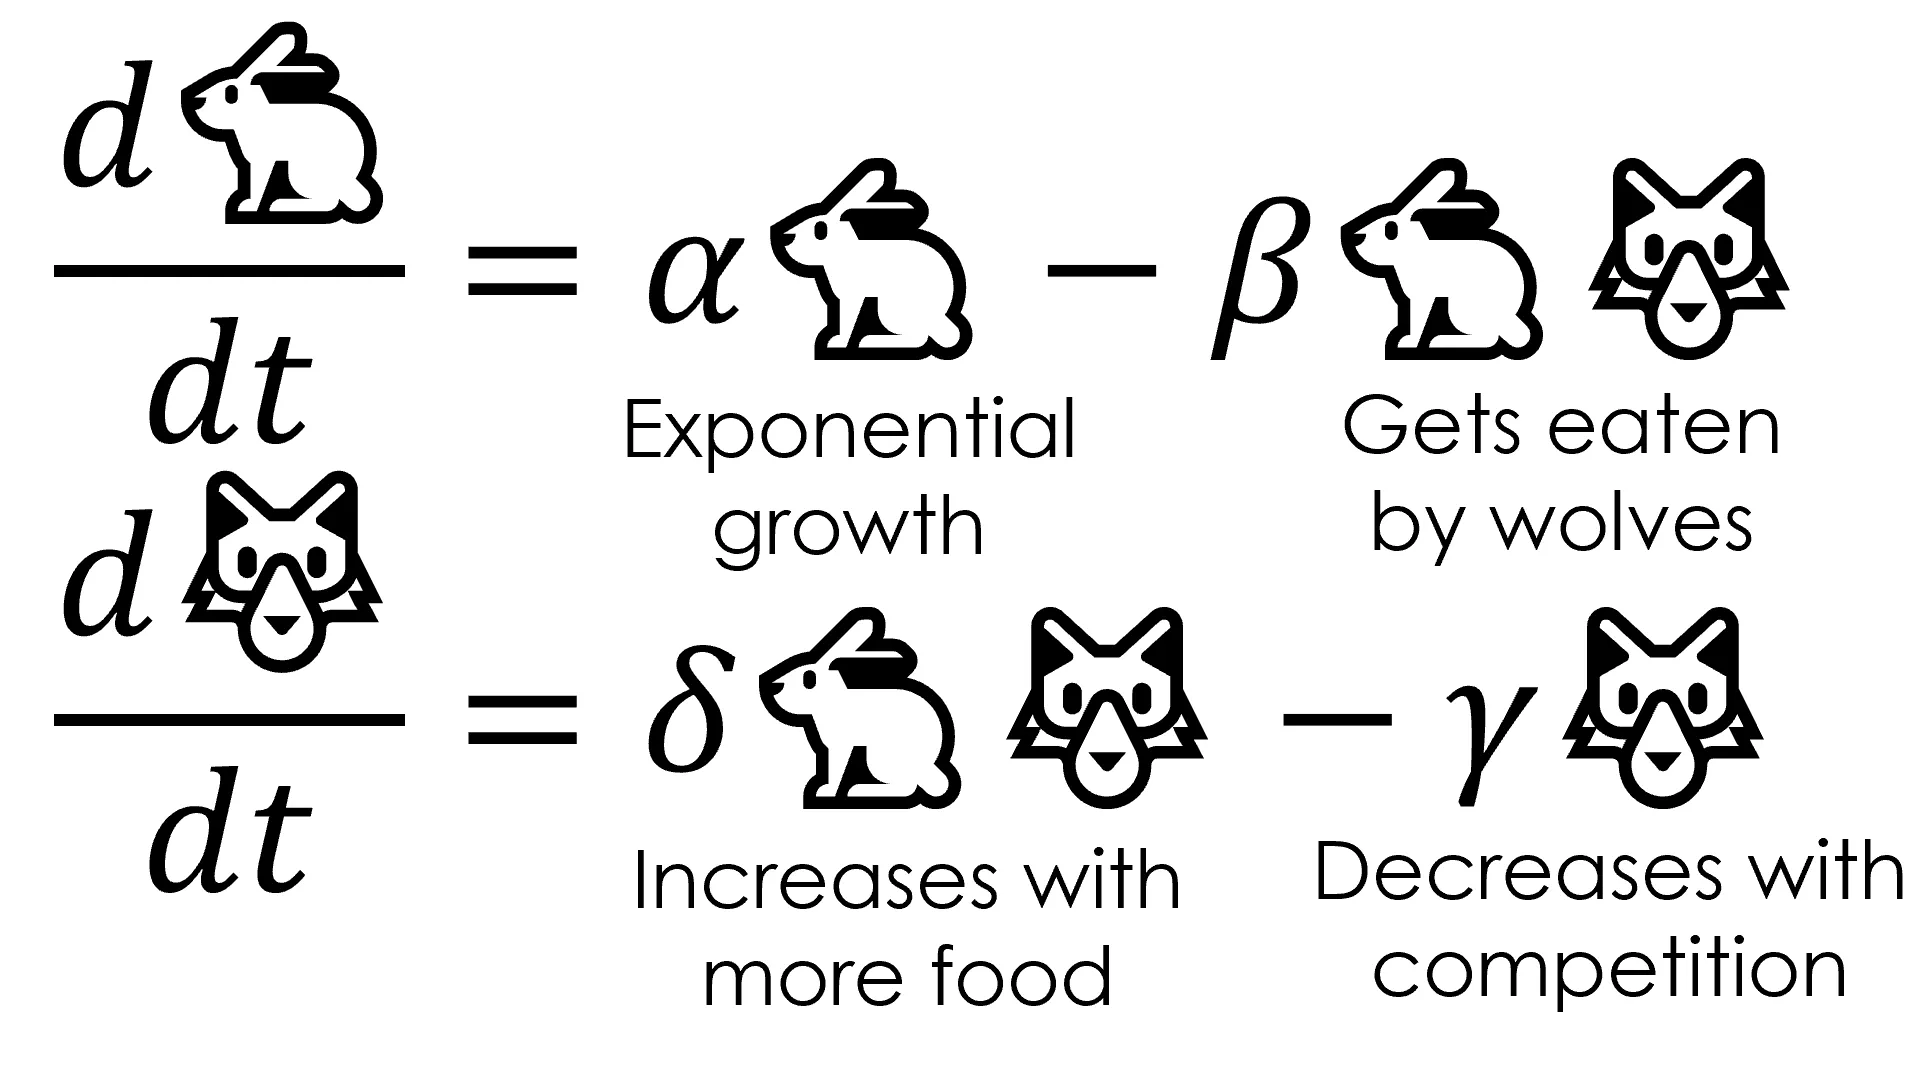

## Let us generate some ground truth data of the L-V model

In [4]:
u0 = torch.tensor([5.0,2.0])  ## initial state
t = torch.linspace(0, 10, 100)  ## time

$$
\begin{align}
 \frac{dx}{dt} &= \alpha x - \beta x y, \\
 \frac{dy}{dt} &= - \gamma y + \delta x y,
\end{align}
$$

In [5]:
class LotkaVolterraODE(torch.nn.Module):

    def __init__(self, trueparam):
        super(LotkaVolterraODE, self).__init__()
        self.trueparam = trueparam
        
    def forward(self, t, u):
        x, y = u[0],u[1]
        du1 = self.trueparam[0] * x + self.trueparam[1] * x * y
        du2 = self.trueparam[2] * y + self.trueparam[3] * x * y
        return torch.stack([du1, du2])

with torch.no_grad():
  sol = odeint(LotkaVolterraODE([1.5, -1.0, -3.0, 1.0]), u0, t, rtol = 1e-8, atol=1e-8, method='rk4')

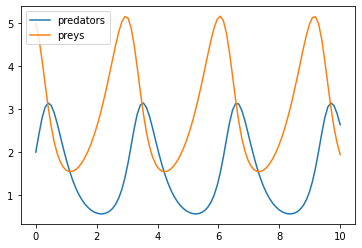

In [6]:
plt.plot(t, sol[:,1],label='predators')
plt.plot(t, sol[:,0],label='preys')
plt.legend()

# Infer Lotka Volterra equations from data

We now will do the inverse, given the ground truth trajectories we will try to retrieve the equation that generated them.

# First case: we have some intuitions about the ODE

The original Lotka Volterra ODE:
$$
\begin{array}{l}
\dot{x}=\alpha x-\beta x y \\
\dot{y}=\gamma x y-\delta y
\end{array}
$$

Let suppose we have the original data and try to approximate it using the following model:

$$
\begin{array}{l}
\dot{x}=p_1 x + p_2 y + p_3 x y \\
\dot{y}=p_4 x + p_5 y + p_6 x y \\
\end{array}
$$

### Define the class "ParamLVODE_V2" that describes our model 
Hint: you can convert the equations into the outcome of a multilayer perceptron (nn.Linear in PyTorch) where the inputs are $x, y, xy$

In [7]:
## ANSWER

class ParamLVODE_V2(torch.nn.Module):

    def __init__(self):
        super(ParamLVODE_V2, self).__init__()
        self.P = nn.Linear(3,2,bias=False) 

    def forward(self, t, u):
        x, y = u[:,0,None],u[:,1,None]
        return self.P(torch.cat([x, y, x*y],axis=1))

### List the initial values of the parameters $p_1, ..,p_6$

In [8]:
## ANSWER
torch.manual_seed(2022)

netw = ParamLVODE_V2().to(device) 
list(netw.P.parameters())

[Parameter containing:
 tensor([[-0.1203,  0.4872,  0.2988],
         [-0.1372, -0.5471, -0.1624]], device='cuda:0', requires_grad=True)]

### Run the model using these initial parameters then plot the prey-predator curves

In [9]:
## ANSWER
# you might have underflow problems if the initial params are bad

netw.eval()
with torch.no_grad():
  Gensol = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')

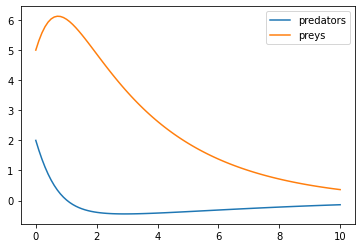

In [10]:
## ANSWER
plt.plot(t, Gensol[:,0,1].detach().cpu(),label='predators')
plt.plot(t, Gensol[:,0,0].detach().cpu(),label='preys')
plt.legend()

# Learning parameters

In [11]:
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(netw.parameters(), lr=learning_rate)#, weight_decay=1e-7
train_loss=[]

In [12]:
def get_batch(batch_time,batch_size):
    ind = torch.from_numpy(np.random.choice(np.arange(batch_time, t.shape[0] - batch_time + 1, dtype=np.int64), batch_size, replace=False))
    #print(ind)
    batch_y0 = sol[ind]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([sol[ind + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

In [13]:
#faster using rk4 instead of dopri5

t_batch = 10 # batch time length
s_batch = 20 # batch size

netw.train()  # Set model to training mode

for epoch in range(1000):
    cum_loss=0.
    optimizer.zero_grad()
    #### since the curves are periodic you can in theory only use one slice of the trajectory but using batches helps SGD converge faster..
    batch_y0, batch_t, batch_y = get_batch(t_batch,s_batch)
    y_pred = odeint(netw, batch_y0.to(device), batch_t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')
    ######## if you want to use only one portion
    #y_pred = odeint(netw, u0[None,:].to(device), t[:t_batch].to(device), rtol = 1e-8, atol=1e-8, method='dopri5')
    #batch_y = sol[:t_batch,None,:]
    ########
    loss = loss_fn(batch_y.to(device),y_pred)         
    loss.backward()
    optimizer.step()

    if  epoch % 10 == 0 and epoch>0:
      with torch.no_grad():
          pred_y = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')
          lossT = loss_fn(pred_y,sol[:,None,:].to(device))
          print('Iter {:04d} | Total Loss {:.6f}'.format(epoch, lossT.item()))
          train_loss.append(lossT.item()) 

    if  epoch % 100 == 0 and epoch>0:
      print(list(netw.P.parameters()))     

Iter 0010 | Total Loss 3.982701
Iter 0020 | Total Loss 3.564959
Iter 0030 | Total Loss 2.780842
Iter 0040 | Total Loss 2.464229
Iter 0050 | Total Loss 2.954904
Iter 0060 | Total Loss 2.973557
Iter 0070 | Total Loss 2.780949
Iter 0080 | Total Loss 2.527016
Iter 0090 | Total Loss 2.678944
Iter 0100 | Total Loss 2.580332
[Parameter containing:
tensor([[ 0.0377,  0.2420, -0.2470],
        [ 0.4768, -0.9019,  0.1147]], device='cuda:0', requires_grad=True)]
Iter 0110 | Total Loss 2.329698
Iter 0120 | Total Loss 2.215406
Iter 0130 | Total Loss 2.082148
Iter 0140 | Total Loss 1.934555
Iter 0150 | Total Loss 1.753335
Iter 0160 | Total Loss 1.572298
Iter 0170 | Total Loss 1.623190
Iter 0180 | Total Loss 1.595223
Iter 0190 | Total Loss 1.435646
Iter 0200 | Total Loss 1.425399
[Parameter containing:
tensor([[ 0.6861,  0.2836, -0.5501],
        [ 0.4454, -1.6488,  0.3573]], device='cuda:0', requires_grad=True)]
Iter 0210 | Total Loss 1.469839
Iter 0220 | Total Loss 1.365049
Iter 0230 | Total Loss 1

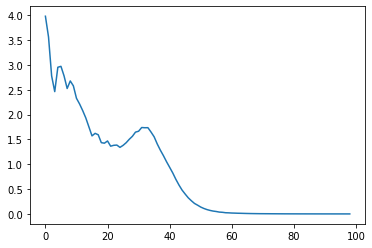

In [14]:
plt.plot(train_loss)

In [15]:
list(netw.P.parameters())

[Parameter containing:
 tensor([[ 1.5033e+00,  8.6347e-03, -1.0049e+00],
         [-3.2268e-05, -2.9850e+00,  9.9639e-01]], device='cuda:0',
        requires_grad=True)]

In [16]:
torch.round(list(netw.P.parameters())[0], decimals=1)

tensor([[ 1.5000,  0.0000, -1.0000],
        [-0.0000, -3.0000,  1.0000]], device='cuda:0',
       grad_fn=<RoundBackward1>)

#### Plot the ground truth and the times series of the learned solution

In [17]:
## ANSWER
netw.eval()
with torch.no_grad():
  Gensol = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')

Text(0.5, 1.0, 'Ground truth solution')

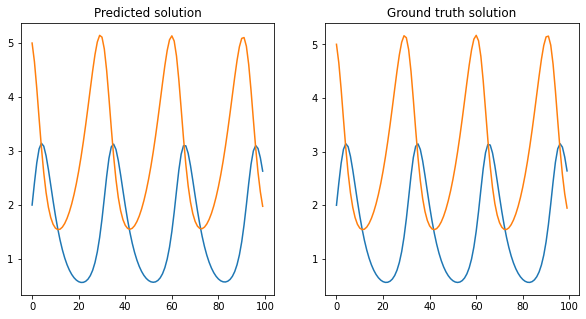

In [18]:
## ANSWER
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(Gensol[:,0,1].detach().cpu())
plt.plot(Gensol[:,0,0].detach().cpu())
plt.title('Predicted solution')

plt.subplot(1,2,2)
plt.plot(sol[:,1].detach().cpu())
plt.plot(sol[:,0].detach().cpu())
plt.title('Ground truth solution')

# Case of completely unknown equations

The original Lotka Volterra ODE:
$$
\begin{array}{l}
\dot{x}=\alpha x-\beta x y \\
\dot{y}=\gamma x y-\delta y
\end{array}
$$

Let suppose we have the original data and try to approximate it using the following model:

$$
\begin{array}{l}
\dot{x},\dot{y}=NN(x,y) \\
\end{array}
$$

### Create the LVNN class to be used to learn the model

Hint: for the neural net, you can use a MLP that takes $x$ and $y$ as input, has 3 hidden layers with 50 neurons each, the outputs $\dot{x},\dot{y}$

In [37]:
## ANSWER
class LVNN(torch.nn.Module):

    def __init__(self):
        super(LVNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        x, y = u[:,0,None],u[:,1,None]
        return self.net(torch.cat([x, y],axis=1))



In [38]:
# you might have underflow problems if the initial params are bad
torch.manual_seed(2022)
netw = LVNN().to(device) 

netw.eval()
with torch.no_grad():
  Gensol = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')

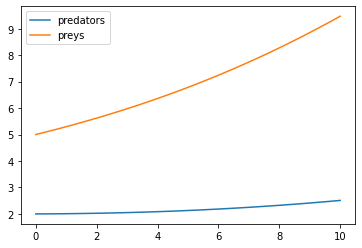

In [39]:
plt.plot(t, Gensol[:,0,1].detach().cpu(),label='predators')
plt.plot(t, Gensol[:,0,0].detach().cpu(),label='preys')
plt.legend()

In [40]:
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(netw.parameters(), lr=learning_rate)#, weight_decay=1e-7
train_loss=[]

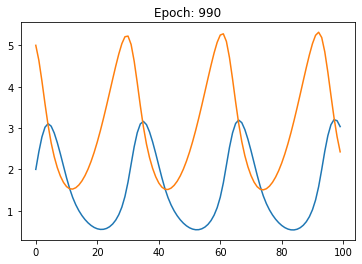

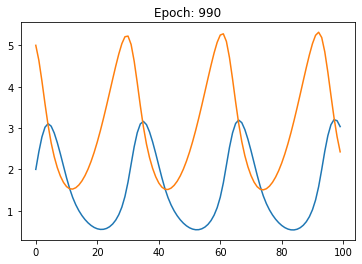

In [41]:
#faster using rk4 instead of dopri5

t_batch = 10 # batch time length
s_batch = 20 # batch size

netw.train()  # Set model to training mode

for epoch in range(1000):
    cum_loss=0.
    optimizer.zero_grad()
    #### since the curves are periodic you can in theory only use one slice of the trajectory but using batches helps SGD converge faster..
    batch_y0, batch_t, batch_y = get_batch(t_batch,s_batch)
    y_pred = odeint(netw, batch_y0.to(device), batch_t.to(device), rtol = 1e-8, atol=1e-8, method='rk4') #####odeint_adjoint !!!
    ######## if you want to use only one portion
    #y_pred = odeint(netw, u0[None,:].to(device), t[:t_batch].to(device), rtol = 1e-8, atol=1e-8, method='dopri5')
    #batch_y = sol[:t_batch,None,:]
    ########
    loss = loss_fn(batch_y.to(device),y_pred)         
    loss.backward()
    optimizer.step()

    if  epoch % 10 == 0 and epoch>0:
      with torch.no_grad():
          plt.clf()
          pred_y = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')
          lossT = loss_fn(pred_y,sol[:,None,:].to(device))
          #print('Iter {:04d} | Total Loss {:.6f}'.format(epoch, lossT.item()))
          train_loss.append(lossT.item()) 
          plt.plot(pred_y[:,0,1].detach().cpu())
          plt.plot(pred_y[:,0,0].detach().cpu())
          plt.title('Epoch: '+ str(epoch)) 
          display.clear_output(wait=True)
          display.display(plt.gcf())   

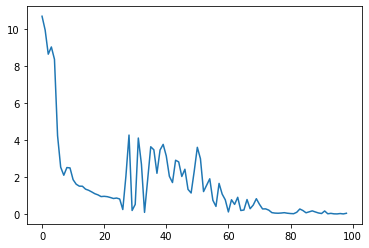

In [42]:
plt.plot(train_loss)

In [43]:
netw.eval()
with torch.no_grad():
  Gensol = odeint(netw, u0[None,:].to(device), t.to(device), rtol = 1e-8, atol=1e-8, method='rk4')

Text(0.5, 1.0, 'Ground truth solution')

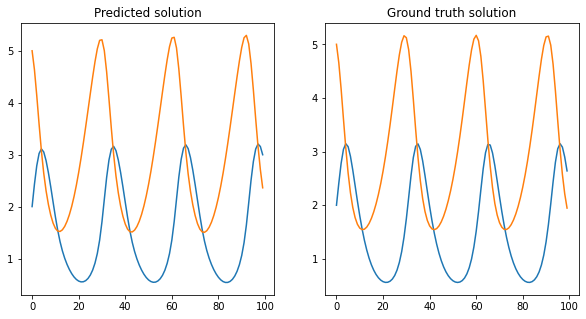

In [44]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(Gensol[:,0,1].detach().cpu())
plt.plot(Gensol[:,0,0].detach().cpu())
plt.title('Predicted solution')

plt.subplot(1,2,2)
plt.plot(sol[:,1].detach().cpu())
plt.plot(sol[:,0].detach().cpu())
plt.title('Ground truth solution')